In [1]:
import seaborn as sns
pd.set_option('display.max_rows', 1000)
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from collections import Counter
%pip install ppscore # installing ppscore, library used to check non-linear relationships between our variables
import ppscore as pps # importing ppscore
import string

seed =2055

plt.style.use('fivethirtyeight')

NameError: name 'pd' is not defined

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [3]:
#Data Read, Data Visualization,EDA Analysis,Data Pre-Processing,Data Splitting

In [4]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test = pd.read_csv('/kaggle/input/titanic/test.csv')

In [5]:
def basic_analysis(df1, df2):
    '''the function compares the average values of  2 dataframes'''
    b = pd.DataFrame()
    b['First df_mean'] = round(df1.mean(),2)
    b['Second df_mean'] = round(df2.mean(),2)
    c = (b['First df_mean']/b['Second df_mean'])
    if [c<=1]:
        b['Variation, %'] = round((1-((b['First df_mean']/b['Second df_mean'])))*100)
    else:
        b['Variation, %'] = round(((b['First df_mean']/b['Second df_mean'])-1)*100)
        
    b['Influence'] = np.where(abs(b['Variation, %']) <= 9, "feature's effect on the target is not defined", 
                              "feature value affects the target")

    return b

In [6]:
train.loc[train['PassengerId'] == 631, 'Age'] = 48

# Passengers with wrong number of siblings and parch
train.loc[train['PassengerId'] == 69, ['SibSp', 'Parch']] = [0,0]
test.loc[test['PassengerId'] == 1106, ['SibSp', 'Parch']] = [0,0]

In [7]:
## checking for Survived dependence of Sex feature
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


**Outlier detection**

In [8]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.7 * IQR                #### increased to 1.7
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])
train.loc[Outliers_to_drop] # Show the outliers rows

NameError: name 'Counter' is not defined

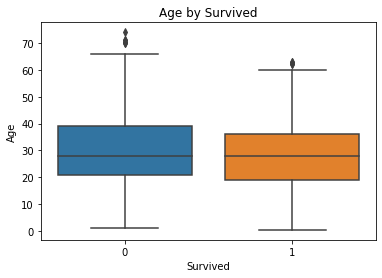

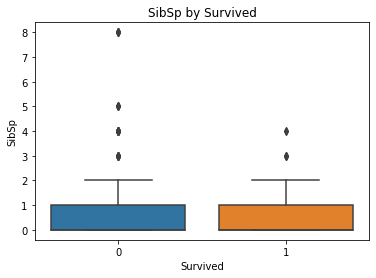

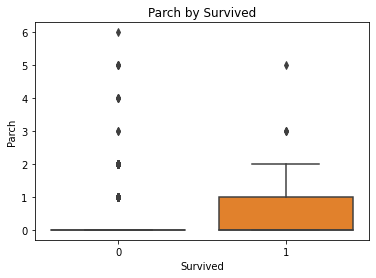

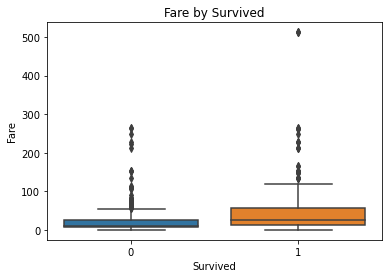

In [9]:
## distribution and checking for outliers in numeric features
import matplotlib.pyplot as plt
features = train[['Age', 'SibSp', 'Parch', 'Fare']].columns
for i in features:
    sns.boxplot(x="Survived",y=i,data=train)
    plt.title(i+" by "+"Survived")
    plt.show()

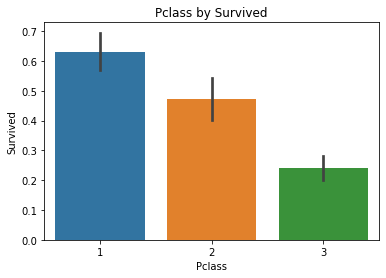

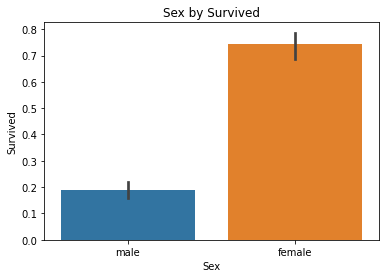

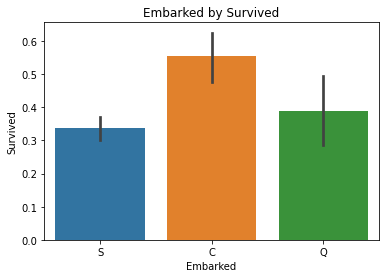

In [10]:
## distribution of cat features
cat_features = train[['Pclass', 'Sex', 'Embarked']].columns
for i in cat_features:
    sns.barplot(y="Survived",x=i,data=train)
    plt.title(i+" by "+"Survived")
    plt.show()

In [11]:
## let's concatenate test and train datasets excluding ID and Target features
df = pd.concat((train.loc[:,'Pclass':'Embarked'], test.loc[:,'Pclass':'Embarked'])).reset_index(drop=True)

In [12]:
survived = train.drop(train[train['Survived'] != 1].index)
not_survived = train.drop(train[train['Survived'] != 0].index)
basic_analysis(survived,not_survived)

,First df_mean,Second df_mean,"Variation, %",Influence
PassengerId,444.37,447.02,1.0,feature's effect on the target is not defined
Survived,1.00,0.00,-inf,feature value affects the target
Pclass,1.95,2.53,23.0,feature value affects the target
Age,28.23,30.63,8.0,feature's effect on the target is not defined
SibSp,0.46,0.55,16.0,feature value affects the target
Parch,0.46,0.33,-39.0,feature value affects the target
Fare,48.40,22.12,-119.0,feature value affects the target


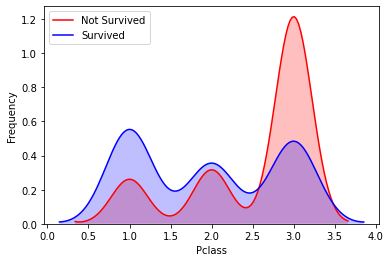

In [13]:
#Pclass
g = sns.kdeplot(train['Pclass'][(train["Survived"] == 0) & (train['Pclass'].notnull())], color="Red", shade = True)
g = sns.kdeplot(train['Pclass'][(train["Survived"] == 1) & (train['Pclass'].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel('Pclass')
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

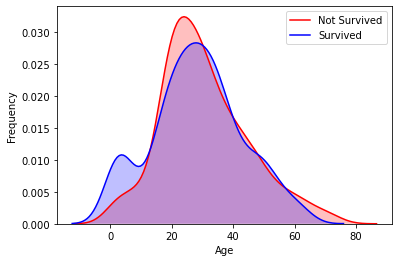

In [14]:
#Age
g = sns.kdeplot(train['Age'][(train["Survived"] == 0) & (train['Age'].notnull())], color="Red", shade = True)
g = sns.kdeplot(train['Age'][(train["Survived"] == 1) & (train['Age'].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel('Age')
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

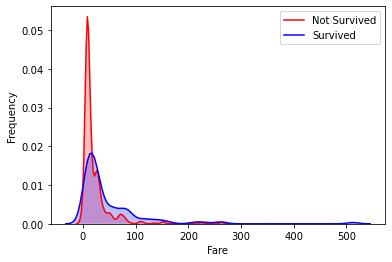

In [15]:
#Fare
g = sns.kdeplot(train['Fare'][(train["Survived"] == 0) & (train['Fare'].notnull())], color="Red", shade = True)
g = sns.kdeplot(train['Fare'][(train["Survived"] == 1) & (train['Fare'].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel('Fare')
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

In [16]:
## PPS matrix of correlation of non-linear relations between features

matrix_pps = pps.matrix(train)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
matrix_pps = matrix_pps.apply(lambda x: round(x, 2))

sns.heatmap(matrix_pps, vmin=0, vmax=1, cmap="icefire", linewidths=0.75, annot=True)

NameError: name 'pps' is not defined

In [17]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.034928,-0.051841,0.002437,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.081552,-0.040707,0.078267,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.367359,0.080151,0.016172,-0.549500
Age,0.034928,-0.081552,-0.367359,1.000000,-0.306489,-0.186467,0.097052
SibSp,-0.051841,-0.040707,0.080151,-0.306489,1.000000,0.411096,0.162533
Parch,0.002437,0.078267,0.016172,-0.186467,0.411096,1.000000,0.218055
Fare,0.012658,0.257307,-0.549500,0.097052,0.162533,0.218055,1.000000


In [18]:
# df feature distribution before features tuning
def basic_details(df):
    b = pd.DataFrame()
    b['Missing value, %'] = round(df.isnull().sum()/df.shape[0]*100)
    b['N unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    return b
basic_details(df)

,"Missing value, %",N unique value,dtype
Pclass,0.0,3,int64
Name,0.0,1307,object
Sex,0.0,2,object
Age,20.0,97,float64
SibSp,0.0,7,int64
Parch,0.0,8,int64
Ticket,0.0,929,object
Fare,0.0,281,float64
Cabin,77.0,186,object
Embarked,0.0,3,object


In [19]:
## for Age imputation let's check its dependence from Pclass
pd.DataFrame(df.groupby('Pclass')['Age'].describe())

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,284.0,39.047254,14.353217,0.92,28.0,39.0,49.25,76.0
2,261.0,29.506705,13.638627,0.67,22.0,29.0,36.00,70.0
3,501.0,24.816367,11.958202,0.17,18.0,24.0,32.00,74.0


Feature Engineering

In [20]:
# New Title feature
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df['Title'] = df['Title'].map(title_mapping)
df['Title'] = df['Title'].fillna(0)

##dropping Name feature
df = df.drop(['Name'], axis=1)

# Convert 'Sex' variable to integer form!
df["Sex"][df["Sex"] == "male"] = 0
df["Sex"][df["Sex"] == "female"] = 1
df["Sex"] = df["Sex"].astype(int)

## Age tuning:
df['Age'] = df.groupby(['Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
df["Age"] = df["Age"].astype(int)

df['Age_cat'] = pd.qcut(df['Age'],q=[0, .16, .33, .49, .66, .83, 1], labels=False, precision=1)



# Ticket tuning
tickets = []
for i in list(df.Ticket):
    if not i.isdigit():
        tickets.append(i.replace(".","").replace("/","").strip().split(" ")[0])
    else:
        tickets.append("x")
df["Ticket"] = tickets
df['Ticket_Frequency'] = df.groupby('Ticket')['Ticket'].transform('count')
df = pd.get_dummies(df, columns= ["Ticket"], prefix = "T")

## Fare tuning:
df['Fare'] = df.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median())) 

df['Zero_Fare'] = df['Fare'].map(lambda x: 1 if x == 0 else (0))


def fare_category(fr): 
    if fr <= 7.91:
        return 1
    elif fr <= 14.454 and fr > 7.91:
        return 2
    elif fr <= 31 and fr > 14.454:
        return 3
    return 4

df['Fare_cat'] = df['Fare'].apply(fare_category) 


# Replace missing values with 'U' for Cabin
df['Cabin'] = df['Cabin'].fillna('U')
import re
# Extract first letter
df['Cabin'] = df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
cabin_category = {'A':9, 'B':8, 'C':7, 'D':6, 'E':5, 'F':4, 'G':3, 'T':2, 'U':1}
# Mapping 'Cabin' to group
df['Cabin'] = df['Cabin'].map(cabin_category)


df["Embarked"] = df["Embarked"].fillna("C")
df["Embarked"][df["Embarked"] == "S"] = 1
df["Embarked"][df["Embarked"] == "C"] = 2
df["Embarked"][df["Embarked"] == "Q"] = 3
df["Embarked"] = df["Embarked"].astype(int)

# New 'familySize' feature & dripping 2 features:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1


df['FamilySize_cat'] = df['FamilySize'].map(lambda x: 1 if x == 1 
                                                            else (2 if 5 > x >= 2 
                                                                  else (3 if 8 > x >= 5 
                                                                       else 4 )
                                                                 ))       

df['Alone'] = [1 if i == 1 else 0 for i in df['FamilySize']]




dummy_col=['Title', 'Sex',  'Age_cat', 'SibSp', 'Parch', 'Fare_cat', 'Embarked', 'Pclass', 'FamilySize_cat']
dummy = pd.get_dummies(df[dummy_col], columns=dummy_col, drop_first=False)
df = pd.concat([dummy, df], axis = 1)


dummy_fare = ['Fare']
dummy_f = pd.get_dummies(df[dummy_fare], columns=dummy_fare, drop_first=True)
df = pd.concat([dummy_f, df], axis = 1)

## some little dance with features
df['FareCat_Sex'] = df['Fare_cat']*df['Sex']
df['Pcl_Sex'] = df['Pclass']*df['Sex']
df['Pcl_Title'] = df['Pclass']*df['Title']
df['Age_cat_Sex'] = df['Age_cat']*df['Sex']
df['Age_cat_Pclass'] = df['Age_cat']*df['Pclass']
df['Title_Sex'] = df['Title']*df['Sex']

df['SmallF'] = df['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
df['MedF']   = df['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df['LargeF'] = df['FamilySize'].map(lambda s: 1 if s >= 5 else 0)
df['Senior'] = df['Age'].map(lambda s:1 if s>70 else 0)

df["Fare"] = df["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipyk

In [21]:
df.shape

(1309, 385)

In [22]:
## adding new featrures
def des_stat_feat(df):
    df = pd.DataFrame(df)
    dcol= [c for c in df.columns if df[c].nunique()>=10]
    d_median = df[dcol].median(axis=0)
    d_mean = df[dcol].mean(axis=0)
    q1 = df[dcol].apply(np.float32).quantile(0.25)
    q3 = df[dcol].apply(np.float32).quantile(0.75)
    
    #Add mean and median column to data set having more then 3 categories
    for c in dcol:
        df[c+str('_median_range')] = (df[c].astype(np.float32).values > d_median[c]).astype(np.int8)
        df[c+str('_mean_range')] = (df[c].astype(np.float32).values > d_mean[c]).astype(np.int8)
        df[c+str('_q1')] = (df[c].astype(np.float32).values < q1[c]).astype(np.int8)
        df[c+str('_q3')] = (df[c].astype(np.float32).values > q3[c]).astype(np.int8)
    return df


In [23]:
df.shape

(1309, 385)

In [24]:
# df after tuning
def basic_details(df):
    b = pd.DataFrame()
    b['Missing value'] = df.isnull().sum()
    b['N unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    return b
basic_details(df)

,Missing value,N unique value,dtype
Fare_3.1708,0,2,uint8
Fare_4.0125,0,2,uint8
Fare_5.0,0,2,uint8
Fare_6.2375,0,2,uint8
Fare_6.4375,0,2,uint8
...,...,...,...
Title_Sex,0,4,int64
SmallF,0,2,int64
MedF,0,2,int64
LargeF,0,2,int64


In [25]:
def reduce_memory_usage(df):
    """ The function will reduce memory of dataframe
    Note: Apply this function after removing missing value"""
    intial_memory = df.memory_usage().sum()/1024**2
    print('Intial memory usage:',intial_memory,'MB')
    for col in df.columns:
        mn = df[col].min()
        mx = df[col].max()
        if df[col].dtype != object:            
            if df[col].dtype == int:
                if mn >=0:
                    if mx < np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)
                    elif mx < np.iinfo(np.uint64).max:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
            if df[col].dtype == float:
                df[col] =df[col].astype(np.float32)
    
    red_memory = df.memory_usage().sum()/1024**2
    print('Memory usage after complition: ',red_memory,'MB')
    
reduce_memory_usage(df)

Intial memory usage: 0.707942008972168 MB
Memory usage after complition:  0.4857339859008789 MB


In [26]:
df = df.loc[:,~df.columns.duplicated()]

In [27]:
df.describe()

,Fare_3.1708,Fare_4.0125,Fare_5.0,Fare_6.2375,Fare_6.4375,Fare_6.45,Fare_6.4958,Fare_6.75,Fare_6.8583,Fare_6.95,...,FareCat_Sex,Pcl_Sex,Pcl_Title,Age_cat_Sex,Age_cat_Pclass,Title_Sex,SmallF,MedF,LargeF,Senior
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,...,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,0.000764,0.000764,0.000764,0.000764,0.002292,0.000764,0.002292,0.001528,0.000764,0.001528,...,1.016807,0.766998,3.841864,0.794500,4.680672,0.872422,0.179526,0.154316,0.061115,0.003056
std,0.027639,0.027639,0.027639,0.027639,0.047836,0.027639,0.047836,0.039073,0.027639,0.039073,...,1.510319,1.154016,2.572536,1.528456,3.784780,1.218391,0.383939,0.361390,0.239633,0.055216
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,6.000000,1.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,4.000000,3.000000,12.000000,5.000000,15.000000,5.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
df.apply(lambda x: sum(x.isnull()),axis=0)

Fare_3.1708    0
Fare_4.0125    0
Fare_5.0       0
Fare_6.2375    0
Fare_6.4375    0
              ..
Title_Sex      0
SmallF         0
MedF           0
LargeF         0
Senior         0
Length: 385, dtype: int64

In [29]:
df.corr()

,Fare_3.1708,Fare_4.0125,Fare_5.0,Fare_6.2375,Fare_6.4375,Fare_6.45,Fare_6.4958,Fare_6.75,Fare_6.8583,Fare_6.95,...,FareCat_Sex,Pcl_Sex,Pcl_Title,Age_cat_Sex,Age_cat_Pclass,Title_Sex,SmallF,MedF,LargeF,Senior
Fare_3.1708,1.000000,-0.000765,-0.000765,-0.000765,-0.001325,-0.000765,-0.001325,-0.001082,-0.000765,-0.001082,...,-0.018622,-0.018384,0.087719,-0.014378,-0.034208,-0.019806,0.059110,-0.011811,-0.007054,-0.001531
Fare_4.0125,-0.000765,1.000000,-0.000765,-0.000765,-0.001325,-0.000765,-0.001325,-0.001082,-0.000765,-0.001082,...,-0.018622,-0.018384,-0.009052,-0.014378,-0.012283,-0.019806,-0.012934,-0.011811,-0.007054,-0.001531
Fare_5.0,-0.000765,-0.000765,1.000000,-0.000765,-0.001325,-0.000765,-0.001325,-0.001082,-0.000765,-0.001082,...,-0.018622,-0.018384,-0.030557,-0.014378,-0.004975,-0.019806,-0.012934,-0.011811,-0.007054,-0.001531
Fare_6.2375,-0.000765,-0.000765,-0.000765,1.000000,-0.001325,-0.000765,-0.001325,-0.001082,-0.000765,-0.001082,...,-0.018622,-0.018384,-0.009052,-0.014378,0.075418,-0.019806,-0.012934,-0.011811,-0.007054,-0.001531
Fare_6.4375,-0.001325,-0.001325,-0.001325,-0.001325,1.000000,-0.001325,-0.002297,-0.001875,-0.001325,-0.001875,...,-0.032279,-0.031867,-0.015690,-0.024923,0.016713,-0.034332,0.019207,-0.020473,-0.012228,-0.002653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Title_Sex,-0.019806,-0.019806,-0.019806,-0.019806,-0.034332,-0.019806,-0.034332,0.004098,-0.019806,0.004098,...,0.907716,0.830344,0.396999,0.768395,-0.058248,1.000000,0.214068,0.173234,0.058148,-0.005565
SmallF,0.059110,-0.012934,-0.012934,-0.012934,0.019207,-0.012934,0.060834,-0.018298,-0.012934,-0.018298,...,0.225520,0.077226,-0.009937,0.176259,-0.020497,0.214068,1.000000,-0.199818,-0.119344,0.010166
MedF,-0.011811,-0.011811,-0.011811,-0.011811,-0.020473,-0.011811,-0.020473,-0.016710,-0.011811,-0.016710,...,0.196947,0.148609,0.227744,0.078216,-0.105919,0.173234,-0.199818,1.000000,-0.108986,-0.023650
LargeF,-0.007054,-0.007054,-0.007054,-0.007054,-0.012228,-0.007054,-0.012228,-0.009980,-0.007054,-0.009980,...,0.130241,0.109589,0.317052,0.005093,-0.109124,0.058148,-0.119344,-0.108986,1.000000,-0.014125


In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [31]:
le = LabelEncoder()
for col in df.select_dtypes('object').columns:
    df[col] = le.fit_transform(df[col])

making feature matrices for modelling

In [32]:
#creating matrices for feature selection:
X_train = df[:train.shape[0]]
X_test_fin = df[train.shape[0]:]
y = train.Survived
X_train['Y'] = y
df = X_train
df.head(20) ## DF for Model training

X = df.drop('Y', axis=1)
y = df.Y

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [33]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=2020)

In [34]:
x_train.head()

,Fare_3.1708,Fare_4.0125,Fare_5.0,Fare_6.2375,Fare_6.4375,Fare_6.45,Fare_6.4958,Fare_6.75,Fare_6.8583,Fare_6.95,...,FareCat_Sex,Pcl_Sex,Pcl_Title,Age_cat_Sex,Age_cat_Pclass,Title_Sex,SmallF,MedF,LargeF,Senior
127,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,3,0,0,0,0,0
349,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,15,0,0,0,0,0
714,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,10,0,0,0,0,0
824,0,0,0,0,0,0,0,0,0,0,...,0,0,12,0,0,0,0,0,1,0
613,0,0,0,0,0,0,0,0,0,0,...,0,0,3,0,3,0,0,0,0,0


In [35]:
y_train

127    1
349    0
714    0
824    0
613    0
      ..
707    1
630    1
323    1
392    0
864    0
Name: Y, Length: 801, dtype: int64

In [36]:
d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_test = xgb.DMatrix(X_test_fin)

params = {
        'objective':'binary:logistic',
        'max_depth':10,
        'learning_rate':0.1,
        'eval_metric':'auc',
        'min_child_weight':1,
        'subsample':0.64,
        'colsample_bytree':0.4,
        'seed':45,
        'reg_lambda':2.79,
        'reg_alpha':0.1,
        'gamma':0,
        'scale_pos_weight':1.68,
#         'n_estimators': 0,
        'nthread':-1
}

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
nrounds=12000  
model = xgb.train(params, d_train, nrounds, watchlist, early_stopping_rounds=100, 
                           maximize=True, verbose_eval=10)

[0]	train-auc:0.88121	valid-auc:0.90304
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[10]	train-auc:0.93133	valid-auc:0.93081
[20]	train-auc:0.94318	valid-auc:0.94779
[30]	train-auc:0.95226	valid-auc:0.94522
[40]	train-auc:0.96191	valid-auc:0.94522
[50]	train-auc:0.96810	valid-auc:0.94239
[60]	train-auc:0.97122	valid-auc:0.93827
[70]	train-auc:0.97496	valid-auc:0.93519
[80]	train-auc:0.97782	valid-auc:0.93056
[90]	train-auc:0.98040	valid-auc:0.93724
[100]	train-auc:0.98217	valid-auc:0.93621
[110]	train-auc:0.98397	valid-auc:0.93364
[120]	train-auc:0.98564	valid-auc:0.93364
Stopping. Best iteration:
[20]	train-auc:0.94318	valid-auc:0.94779



In [37]:
accuracy = pd.DataFrame()
accuracy['predict'] = model.predict(d_valid)
accuracy['predict'] = accuracy['predict'].apply(lambda x: 1 if x>0.6 else 0)
accuracy_score(y_valid, accuracy['predict'])

0.9111111111111111

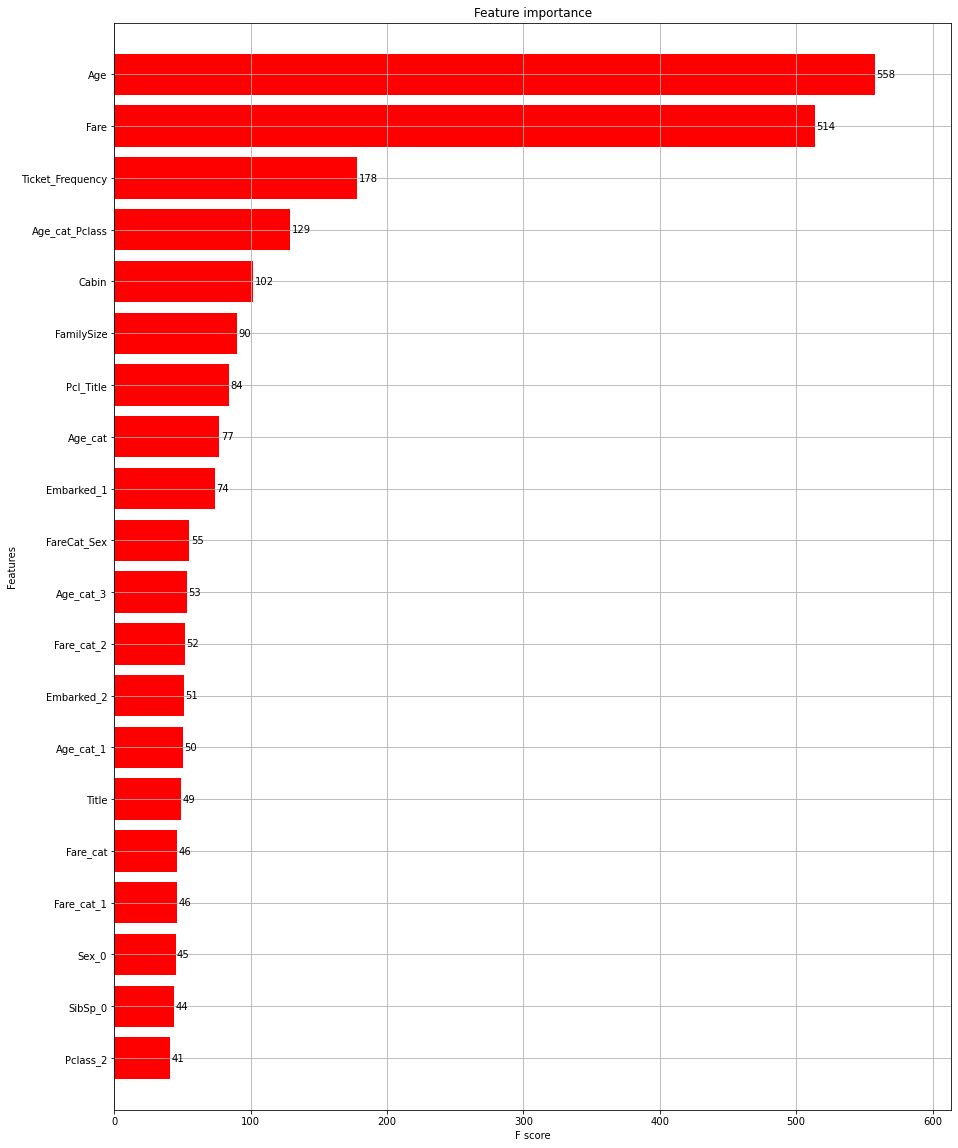

In [38]:
fig,ax = plt.subplots(figsize=(15,20))
xgb.plot_importance(model,ax=ax,max_num_features=20,height=0.8,color='r')
# plt.tight_layout()
plt.show()

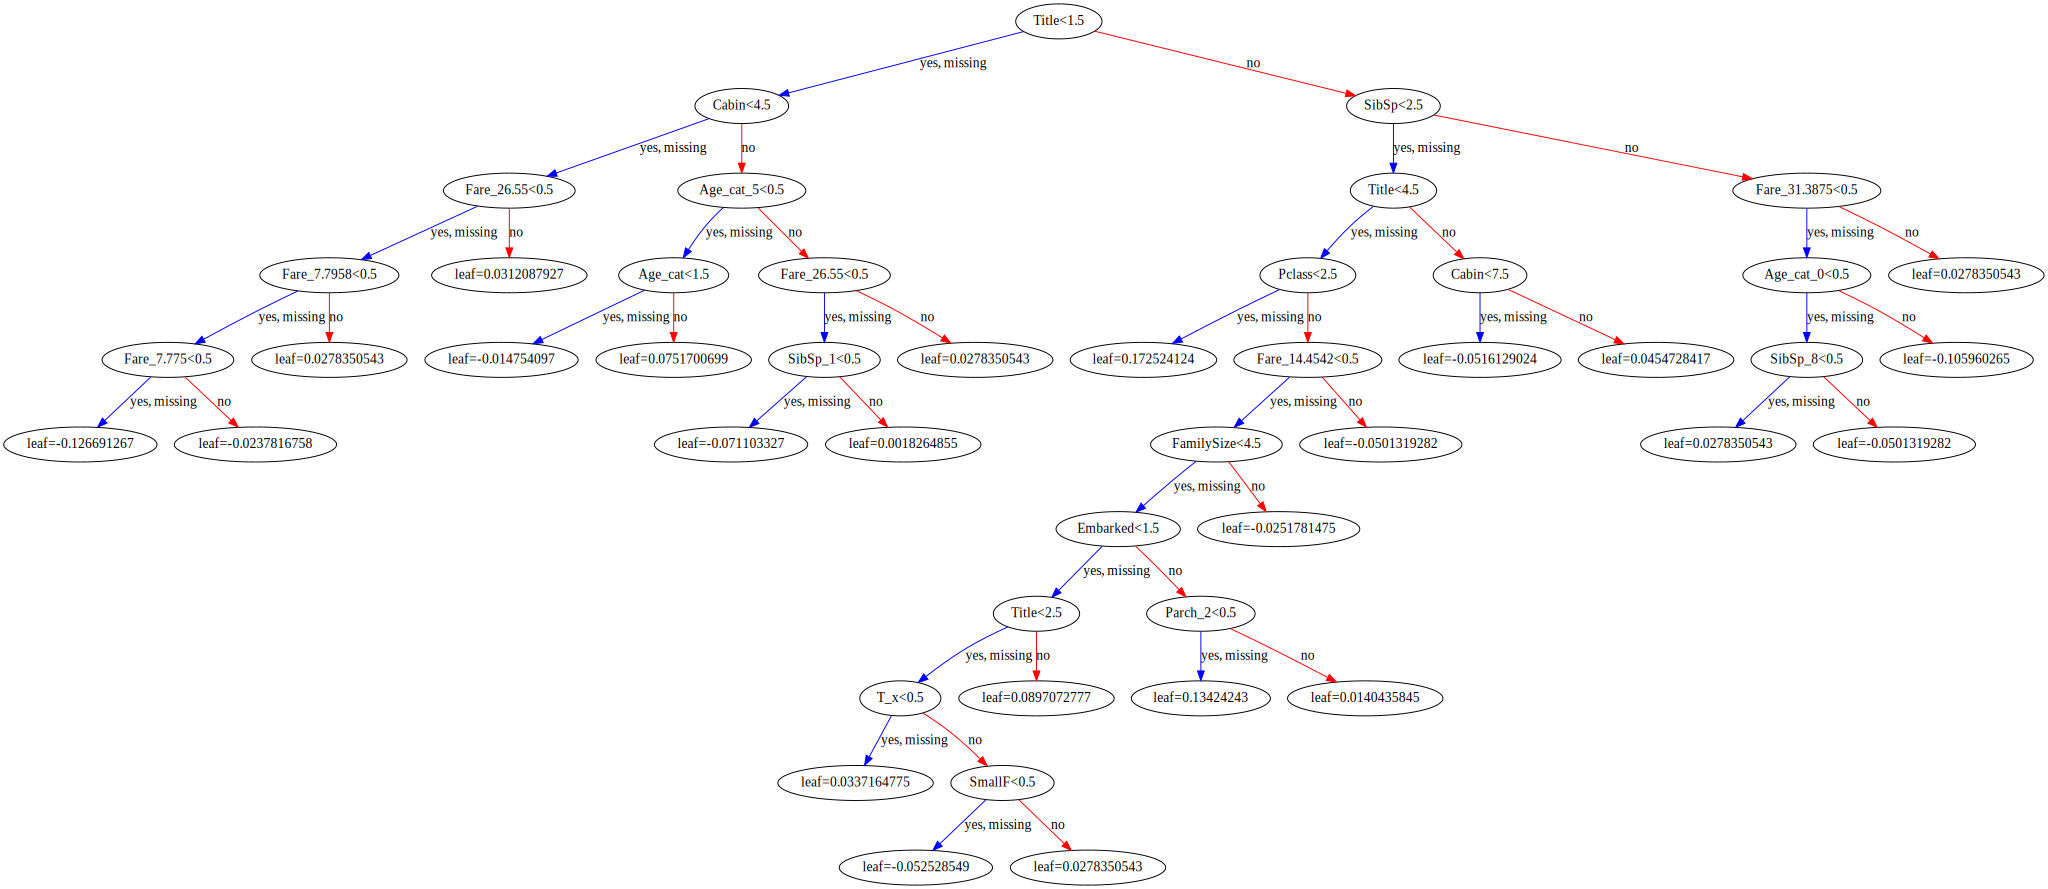

In [39]:
xgb.to_graphviz(model)

In [40]:
sub = pd.DataFrame()
sub['PassengerId'] = test['PassengerId']
sub['Survived'] = model.predict(d_test)
sub['Survived'] = sub['Survived'].apply(lambda x: 1 if x>0.6 else 0)

In [41]:
 leaks = {
 897:1,
 899:1, 
 930:1,
 932:1,
 949:1,
 987:1,
 995:1,
 998:1,
 999:1,
 1016:1,
 1047:1,
 1083:1,
 1097:1,
 1099:1,
 1103:1,
 1115:1,
 1118:1,
 1135:1,
 1143:1,
 1152:1, 
 1153:1,
 1171:1,
 1182:1,
 1192:1,
 1203:1,
 1233:1,
 1250:1,
 1264:1,
 1286:1,
 935:0,
 957:0,
 972:0,
 988:0,
 1004:0,
 1006:0,
 1011:0,
 1105:0,
 1130:0,
 1138:0,
 1173:0,
 1284:0,
 }

In [42]:

sub['Survived'] = sub.apply(lambda r: leaks[int(r['PassengerId'])] if int(r['PassengerId']) in leaks else r['Survived'], axis=1)
sub.to_csv('submission.csv', index=False)

sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0


In [43]:
#If u like this Notebbok, Upvote this Kernel